# Обработка потокового видео

In [1]:
import cv2
from IPython.display import Image
from IPython import display
import numpy as np
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def draw_frame (img, x, y, w, h, text=None, frame_color=(121, 240, 255)):
    
    # Параметры надписи
    font_size = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_width = 2
    font_color = (0, 0, 0)
    text_shift = 10
    
    # Параметры рамки
    frame_width = 2
    #frame_color = (121, 240, 255)

    # Координаты рамки
    x1 = x - w // 2
    x2 = x + w // 2
    y1 = y - h // 2
    y2 = y + h // 2
    
    # Рисуем рамку
    cv2.rectangle(img, (x1, y1), (x2, y2), frame_color, frame_width)
    
    # Если есть текст, отображаем его
    if text != None:
        # Определяем размеры окружающей текст рамки
        label_size=cv2.getTextSize(text,font,font_size,font_width)
        caption_w = label_size[0][0] + text_shift*2
        caption_h = label_size[0][1] + text_shift*2

        # Рисуем фон для надписи
        cv2.rectangle(img, (x1, y1), (x1 + caption_w, y1 - caption_h), frame_color, -1)
        cv2.rectangle(img, (x1, y1), (x1 + caption_w, y1 - caption_h), frame_color, frame_width)
        
        # Определяем координаты надписи и отображаем ее
        text_x = x1 + caption_w // 2 - label_size[0][0] // 2
        text_y = y1 - caption_h // 2 + label_size[0][1] // 2
        cv2.putText(img, text, (text_x, text_y), font, font_size, font_color, font_width)

In [3]:
def draw_lots_count(img, total, occupied):
    
    # Параметры надписи
    font_size = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_width = 2
    font_color = (121, 240, 255)
    x = 20
    y = 50
    
    cv2.putText(img, "Occupied: {0}/{1}".format(occupied,total), (x, y), font, font_size, font_color, font_width)
    return img

In [4]:
net = cv2.dnn.readNet("yolov3/yolov3.weights","yolov3/yolov3.cfg")
with open("yolov3/coco.names.txt") as f:
    labels = f.read().strip().split('\n')
layer_names = net.getLayerNames()
out_layer_indexes = [index[0] - 1 for index in net.getUnconnectedOutLayers()]
out_layer_names = [layer_names[index] for index in out_layer_indexes]

In [5]:
parking_coords = [0, 500, 270, 600]

def check_car_coords(x, y, coords=parking_coords):
    if (coords[0] < x < coords[1] and coords[2] < y < coords[3]):
        return True
    return False
        

In [6]:
def apply_yolo(img):
    height, width, _ = img.shape
    size = (608, 608)
    
    blob = cv2.dnn.blobFromImage(img, 1/255,  size, swapRB=True)
    net.setInput(blob)
    out_layers = net.forward(out_layer_names)
    
    object_boxes = []
    object_probas = []
    object_labels = []
    car_counter = 0

    
    for layer in out_layers:
        for result in layer:
            x, y, w, h = result[:4]
            x = int(x * width)
            y = int(y * height)
            w = int(w * width)
            h = int(h * height)
            probas = result[5:]
            max_proba_index = np.argmax(probas)
            max_proba = probas[max_proba_index]
            if max_proba > 0:
                object_boxes.append([x, y, w, h])
                object_probas.append(float(max_proba))
                object_labels.append(labels[max_proba_index])
                
    filtered_boxes = cv2.dnn.NMSBoxes(object_boxes, object_probas, 0.0, 0.3)

    for index_arr in filtered_boxes:
        index = index_arr[0]
        x, y, w, h = object_boxes[index]
        label = object_labels[index]
        #if label == "car":
        if check_car_coords(x, y):
            car_counter += 1
            draw_frame(img, x, y, w, h)
        else:
            draw_frame(img, x, y, w, h, frame_color=(0, 0, 255))
        
    return (car_counter, img)

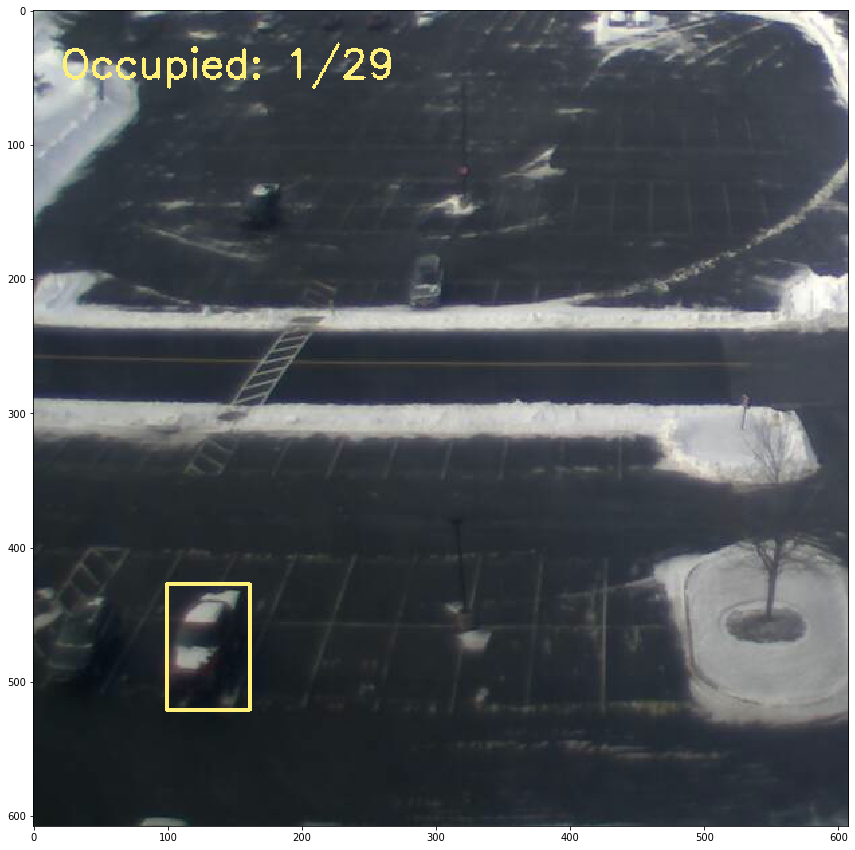

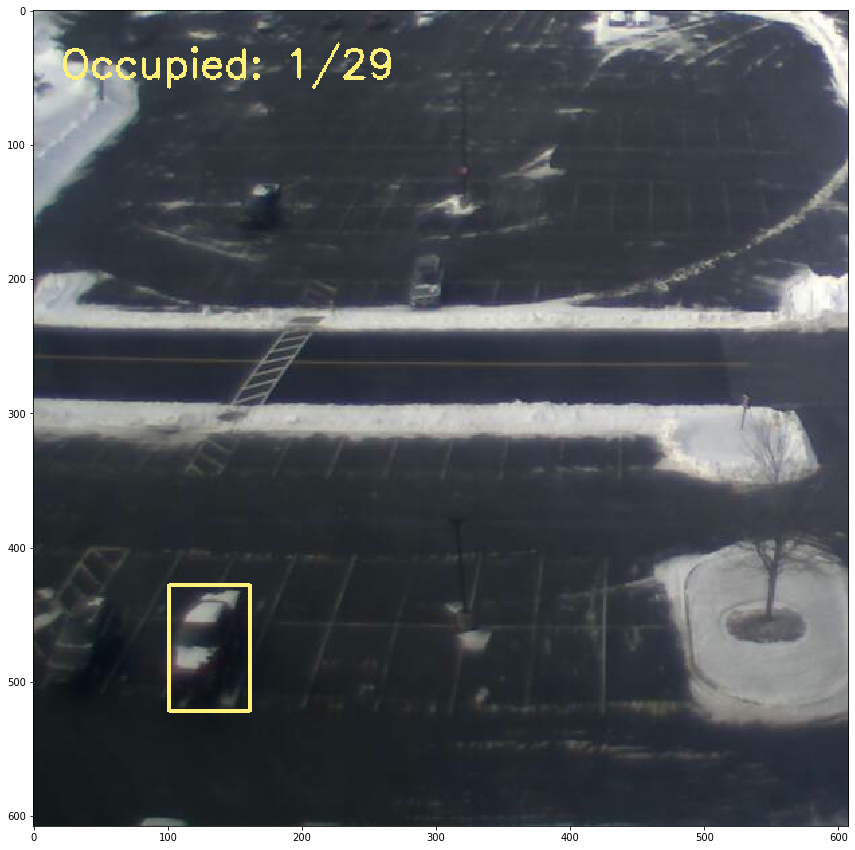

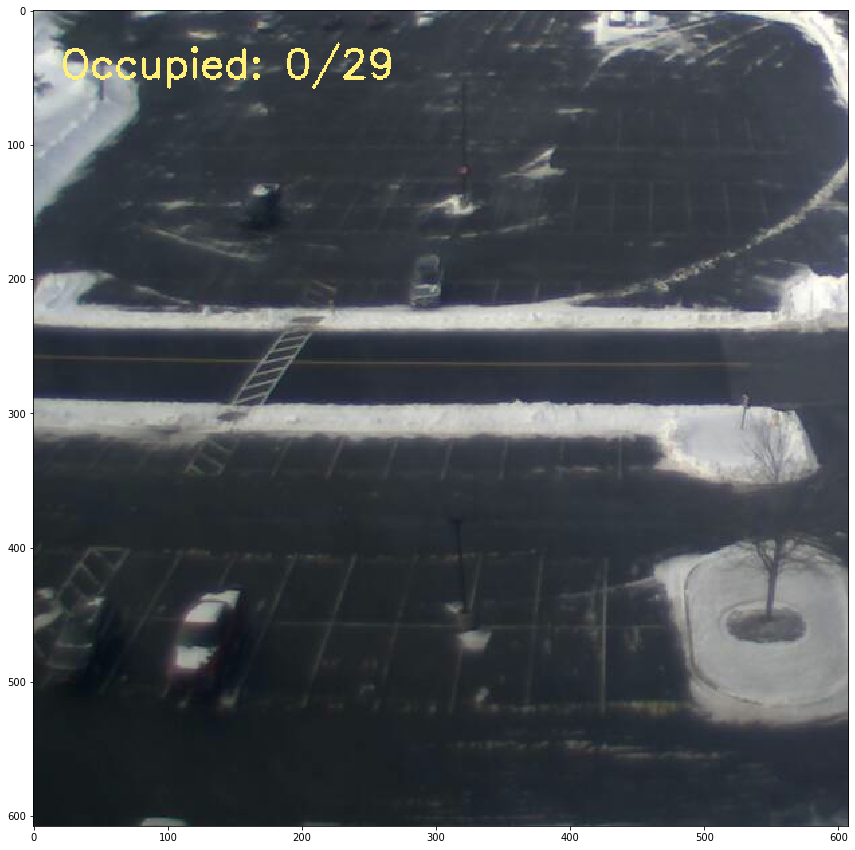

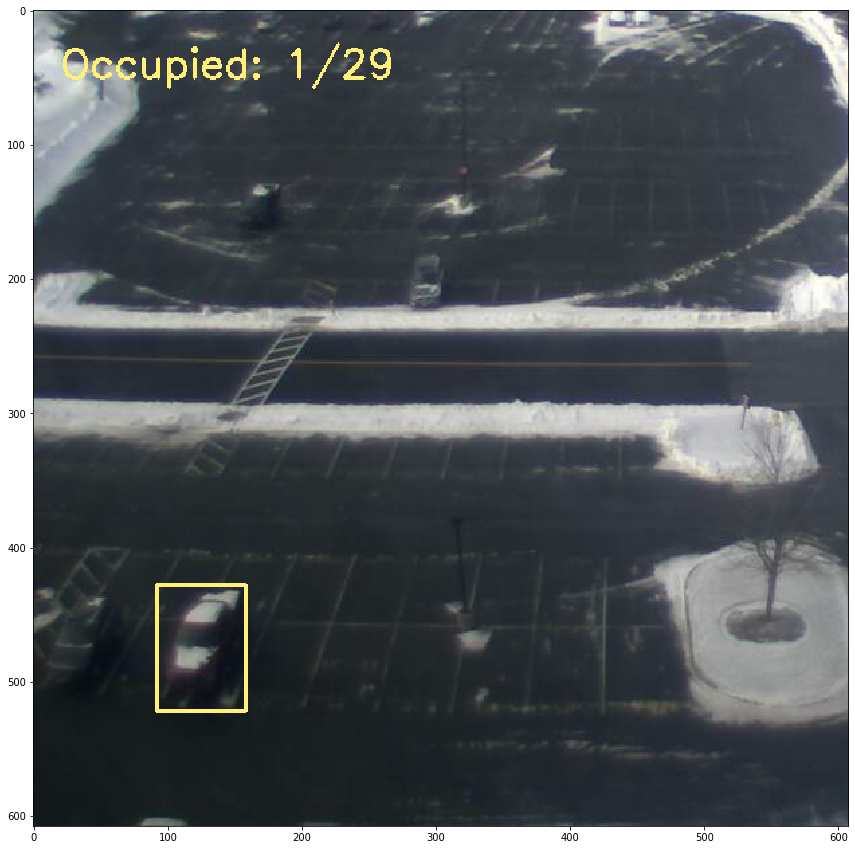

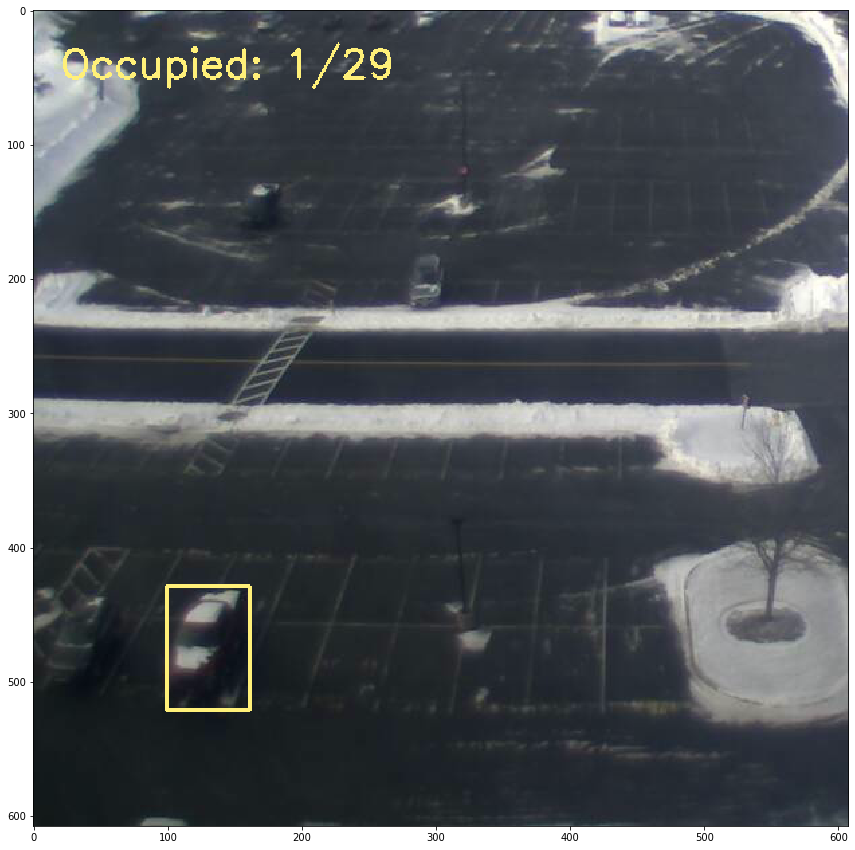

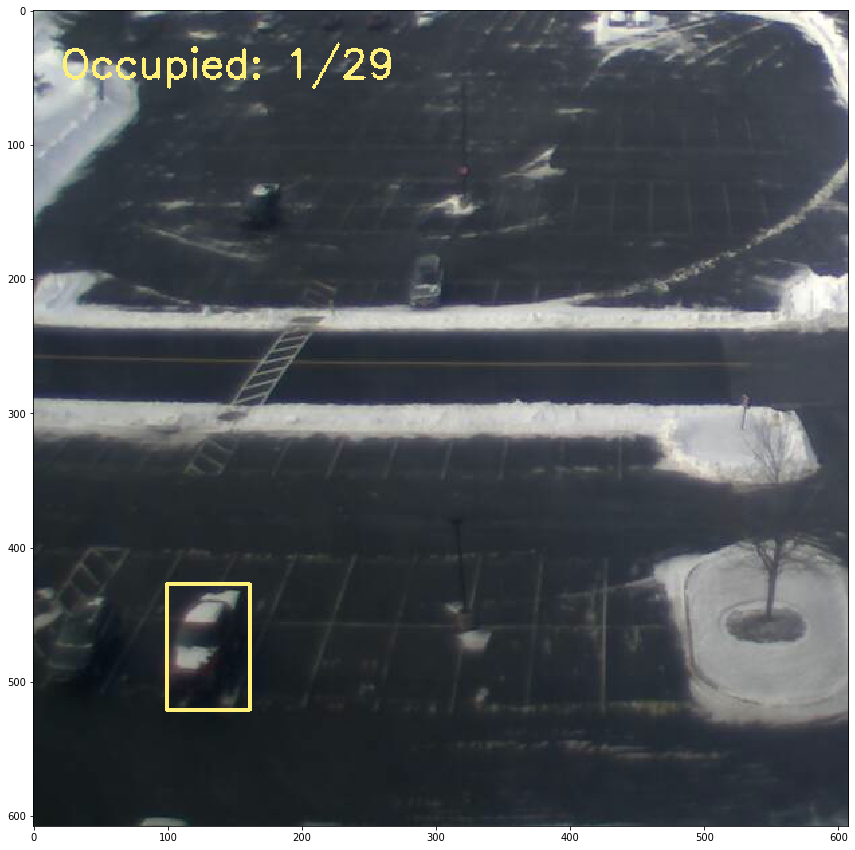

In [8]:
parking_lots = 29
#history = np.array([(-1,-1)])
history_time = 30

cap = cv2.VideoCapture('http://96.56.250.139:8200/mjpg/video.mjpg#.X9pWjjXS-8w.link')

for i in range(5):

    res, frame = cap.read()
    if not res:
        break
    
    frame = frame[-608:, :608]
    car_counter, frame = apply_yolo(frame)
    car_counter = min(car_counter, parking_lots)
    
    #np.append(history, [time.time(), car_counter])
    #filt_history = np.array([tup for tup in history if tup[0] >= time.time() - history])
    
    frame = draw_lots_count(frame, parking_lots, car_counter)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    
    plt.figure(figsize=(20, 15))
    plt.imshow(frame)
    display.clear_output(wait=True)
    display.display(plt.gcf())

cap.release()

In [162]:
history

array([[-1, -1]])